# Protein-Based AD vs CN Classification

This notebook builds classifiers to predict research_group (AD vs CN) using proteomic features.

**Dataset**: `proteomic_w_labels.csv` - Proteomic data with AD/CN labels

**Goal**: Compare different classification approaches and evaluate performance


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif

# Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

# PyTorch for Transformer
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.base import BaseEstimator, ClassifierMixin

# Evaluation
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, 
    roc_curve, precision_recall_curve, accuracy_score
)

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('default')
sns.set_palette("husl")

print("📦 Libraries imported successfully!")


📦 Libraries imported successfully!


## 0.1 Create test set- the unique patients with both proteins and MRI images

In [38]:
protein_mri_merged = "D:\ADNI\AD_CN\proteomics\Biomarkers Consortium Plasma Proteomics MRM\protein_mri_merged.csv"
protein_mri_df = pd.read_csv(protein_mri_merged)
protein_mri_df = protein_mri_df[protein_mri_df["MRI_acquired"] == 1]
print('protein_mri_df length:', len(protein_mri_df))
unique_rid_count = protein_mri_df["RID"].nunique()
print('unique_rid_count:', unique_rid_count)
protein_mri_df.head()

protein_mri_df length: 45
unique_rid_count: 39


,RID,VISCODE,A1AT_AVLTIDEK,A1AT_LSITGTYDLK,A1AT_SVLGQLGITK,A1BG_NGVAQEPVHLDSPAIK,A1BG_SGLSTGWTQLSK,A2GL_DLLLPQPDLR,A2GL_VAAGAFQGLR,A4_LVFFAEDVGSNK,...,VASN_NLHDLDVSDNQLER,VASN_SLTLGIEPVSPTSLR,VASN_YLQGSSVQLR,VGF_AYQGVAAPFPK,VGF_NSEPQDEGELFQGVDPR,VGF_THLGEALAPLSK,VTDB_EFSHLGK,VTDB_HLSLLTTLSNR,VTDB_VPTADLEDVLPLAEDITNILSK,MRI_acquired
10,29,bl,9.81517,6.18333,9.90790,15.2579,19.7972,25.5598,22.6321,16.9843,...,14.2841,12.0111,15.4368,16.6980,18.5111,15.6030,9.30516,19.3529,15.5592,1.0
11,31,bl,11.47870,8.40126,10.27990,15.2515,20.1433,25.5309,22.5913,18.5660,...,13.7613,11.9394,15.6215,18.0261,20.0938,17.3672,9.48204,19.7264,15.5529,1.0
23,61,bl,10.18860,6.23358,9.61912,14.4271,18.7907,25.1511,22.3402,17.8330,...,14.4799,11.7326,15.2672,17.6097,19.4434,16.5036,9.35153,19.7352,15.9718,1.0
30,86,bl,10.01540,7.65575,9.62980,15.1688,19.9732,25.7705,22.9720,17.7610,...,14.3913,11.9590,15.4881,17.4063,19.1248,16.3361,9.60956,19.6129,15.5508,1.0
45,139,bl,11.81060,9.80430,11.39900,14.1750,18.9025,24.5364,21.6113,17.4985,...,14.2662,11.9110,15.3937,17.1684,18.9852,16.3450,9.09269,18.7047,14.5963,1.0


In [ ]:
proteomic_w_labels = "D:\ADNI\AD_CN\proteomics\Biomarkers Consortium Plasma Proteomics MRM\proteomic_w_labels.csv"
protein_labels_df = pd.read_csv(proteomic_w_labels)
print('protein_labels_df length:', len(protein_labels_df))
protein_labels_df.head()


protein_labels_df length: 158


,RID,VISCODE,A1AT_AVLTIDEK,A1AT_LSITGTYDLK,A1AT_SVLGQLGITK,A1BG_NGVAQEPVHLDSPAIK,A1BG_SGLSTGWTQLSK,A2GL_DLLLPQPDLR,A2GL_VAAGAFQGLR,A4_LVFFAEDVGSNK,...,VASN_SLTLGIEPVSPTSLR,VASN_YLQGSSVQLR,VGF_AYQGVAAPFPK,VGF_NSEPQDEGELFQGVDPR,VGF_THLGEALAPLSK,VTDB_EFSHLGK,VTDB_HLSLLTTLSNR,VTDB_VPTADLEDVLPLAEDITNILSK,research_group,subject_age
0,3,bl,10.09220,7.74523,10.17220,16.6720,21.4594,26.9142,24.2002,17.5886,...,12.4679,15.9046,16.7334,18.3733,15.7735,10.82520,21.7876,17.6057,AD,81.30
1,5,bl,9.98930,6.60892,9.68137,15.2048,19.7987,25.7420,22.8861,18.0174,...,12.1692,15.7139,17.9062,19.4055,16.8510,9.17437,19.1255,15.0267,CN,73.73
2,8,bl,9.81022,7.65311,10.21570,15.6723,20.3279,25.4989,22.4874,18.6170,...,13.1469,16.5607,19.6158,21.2765,18.4325,9.86449,20.2941,16.1640,CN,84.50
3,10,bl,8.92968,7.58228,9.95119,15.7266,20.1880,26.0936,23.2094,18.1481,...,12.4011,15.8251,17.6525,19.5023,16.5219,9.27747,19.8080,15.8384,AD,73.90
4,14,bl,8.26976,8.11458,9.43450,16.1504,20.8818,26.1298,23.2628,18.1906,...,12.6767,16.1722,17.8690,19.3958,16.8191,9.86389,20.2600,16.0890,CN,78.54


In [ ]:
def merge_protein_data(protein_mri_df, protein_labels_df):
    """
    Merge protein_mri_df with research_group and subject_age from protein_labels_df
    based on matching RID values
    
    Parameters:
    -----------
    protein_mri_df : DataFrame
        Contains RID, VISCODE, 320 protein measurements, and MRI_acquired
    protein_labels_df : DataFrame
        Contains RID, VISCODE, 320 protein measurements, research_group, and subject_age
    
    Returns:
    --------
    DataFrame
        Merged DataFrame with all columns from protein_mri_df plus research_group and subject_age
    """
    
    print("🔍 Starting protein data merge...")
    print(f"   • protein_mri_df shape: {protein_mri_df.shape}")
    print(f"   • protein_labels_df shape: {protein_labels_df.shape}")
    
    # Check required columns exist
    required_mri_cols = ['RID', 'VISCODE', 'MRI_acquired']
    required_labels_cols = ['RID', 'VISCODE', 'research_group', 'subject_age']
    
    for col in required_mri_cols:
        if col not in protein_mri_df.columns:
            raise ValueError(f"Column '{col}' not found in protein_mri_df")
    
    for col in required_labels_cols:
        if col not in protein_labels_df.columns:
            raise ValueError(f"Column '{col}' not found in protein_labels_df")
    
    # Get unique RIDs in each DataFrame
    mri_rids = set(protein_mri_df['RID'].unique())
    labels_rids = set(protein_labels_df['RID'].unique())
    
    print(f"\n📊 RID Analysis:")
    print(f"   • Unique RIDs in protein_mri_df: {len(mri_rids)}")
    print(f"   • Unique RIDs in protein_labels_df: {len(labels_rids)}")
    
    # Find overlapping RIDs
    overlapping_rids = mri_rids.intersection(labels_rids)
    missing_from_labels = mri_rids - labels_rids
    missing_from_mri = labels_rids - mri_rids
    
    print(f"   • Overlapping RIDs: {len(overlapping_rids)}")
    print(f"   • RIDs in MRI but missing from labels: {len(missing_from_labels)}")
    print(f"   • RIDs in labels but missing from MRI: {len(missing_from_mri)}")
    
    if missing_from_labels:
        print(f"\n⚠️ RIDs in MRI data but missing from labels (first 10): {list(missing_from_labels)[:10]}")
    
    # Merge the DataFrames on RID
    # This will keep all rows from protein_mri_df and add research_group and subject_age
    merged_df = protein_mri_df.merge(
        protein_labels_df[['RID', 'research_group', 'subject_age']], 
        on='RID', 
        how='left'
    )    
    # Check merge results
    merged_count = merged_df['research_group'].notna().sum()
    total_rows = len(merged_df)
    
    print(f"\n✅ Merge Results:")
    print(f"   • Rows with research_group data: {merged_count}")
    print(f"   • Rows without research_group data: {total_rows - merged_count}")
    print(f"   • Success rate: {(merged_count/total_rows)*100:.1f}%")
    print(f"   • Final merged DataFrame shape: {merged_df.shape}")
    
    # Show sample of the merged data
    print(f"\n📋 Sample of merged data:")
    sample_cols = ['RID', 'VISCODE', 'MRI_acquired', 'research_group', 'subject_age']
    available_cols = [col for col in sample_cols if col in merged_df.columns]
    print(merged_df[available_cols].head(10))
    
    return merged_df

# Example usage:
if __name__ == "__main__":
    # Assuming your DataFrames are already loaded
    # protein_mri_df = pd.read_csv('your_mri_file.csv')
    # protein_labels_df = pd.read_csv('your_labels_file.csv')
    
    # Merge the data
    merged_df = merge_protein_data(protein_mri_df, protein_labels_df)
    
    # Save the merged data if needed
    merged_df.to_csv('D:\ADNI\AD_CN\proteomics\Biomarkers Consortium Plasma Proteomics MRM\proteomic_mri_with_labels.csv', index=False)

🔍 Starting protein data merge...
   • protein_mri_df shape: (45, 323)
   • protein_labels_df shape: (158, 325)

📊 RID Analysis:
   • Unique RIDs in protein_mri_df: 39
   • Unique RIDs in protein_labels_df: 152
   • Overlapping RIDs: 39
   • RIDs in MRI but missing from labels: 0
   • RIDs in labels but missing from MRI: 113

✅ Merge Results:
   • Rows with research_group data: 55
   • Rows without research_group data: 0
   • Success rate: 100.0%
   • Final merged DataFrame shape: (55, 325)

📋 Sample of merged data:
   RID VISCODE  MRI_acquired research_group  subject_age
0   29      bl           1.0             AD        64.16
1   31      bl           1.0             CN        77.75
2   61      bl           1.0             CN        77.12
3   86      bl           1.0             CN        80.32
4  139      bl           1.0             AD        65.86
5  139      bl           1.0             AD        65.86
6  139      bl           1.0             AD        65.86
7  139      bl         

## 0.2 Create train set with cross-val folds

In [ ]:
print('protein_labels_df length:', len(protein_labels_df))
print('protein_mri_df length:', len(protein_mri_df))
# Remove rows from protein_labels_df where RID exists in protein_mri_df
protein_train_df = protein_labels_df[~protein_labels_df['RID'].isin(protein_mri_df['RID'])]
print('protein_train_df length:', len(protein_train_df))
unique_rid_count = protein_train_df["RID"].nunique()
print('unique_rid_count in protein_train_df:', unique_rid_count)
# protein_train_df.head()


protein_labels_df length: 158
protein_mri_df length: 45
protein_train_df length: 114
unique_rid_count in protein_train_df: 113


,RID,VISCODE,A1AT_AVLTIDEK,A1AT_LSITGTYDLK,A1AT_SVLGQLGITK,A1BG_NGVAQEPVHLDSPAIK,A1BG_SGLSTGWTQLSK,A2GL_DLLLPQPDLR,A2GL_VAAGAFQGLR,A4_LVFFAEDVGSNK,...,VASN_YLQGSSVQLR,VGF_AYQGVAAPFPK,VGF_NSEPQDEGELFQGVDPR,VGF_THLGEALAPLSK,VTDB_EFSHLGK,VTDB_HLSLLTTLSNR,VTDB_VPTADLEDVLPLAEDITNILSK,research_group,subject_age,MRI_acquired
0,3,bl,10.09220,7.74523,10.17220,16.6720,21.4594,26.9142,24.2002,17.5886,...,15.9046,16.7334,18.3733,15.7735,10.82520,21.7876,17.6057,AD,81.30,NaN
1,5,bl,9.98930,6.60892,9.68137,15.2048,19.7987,25.7420,22.8861,18.0174,...,15.7139,17.9062,19.4055,16.8510,9.17437,19.1255,15.0267,CN,73.73,NaN
2,8,bl,9.81022,7.65311,10.21570,15.6723,20.3279,25.4989,22.4874,18.6170,...,16.5607,19.6158,21.2765,18.4325,9.86449,20.2941,16.1640,CN,84.50,NaN
3,10,bl,8.92968,7.58228,9.95119,15.7266,20.1880,26.0936,23.2094,18.1481,...,15.8251,17.6525,19.5023,16.5219,9.27747,19.8080,15.8384,AD,73.90,NaN
4,14,bl,8.26976,8.11458,9.43450,16.1504,20.8818,26.1298,23.2628,18.1906,...,16.1722,17.8690,19.3958,16.8191,9.86389,20.2600,16.0890,CN,78.54,NaN


In [54]:
# Check for research_group column in protein_train_df
if 'research_group' in protein_train_df.columns:
    print(f"\n🎯 Target variable found: 'research_group'")
    print(f"   • Class distribution: {protein_train_df['research_group'].value_counts().to_dict()}")
else:
    print(f"\n❌ 'research_group' column not found!")
    print(f"   Available columns: {list(protein_train_df.columns)}")

# Prepare data for splitting
metadata_cols = ['RID', 'VISCODE', 'research_group','subject_age', 'MRI_acquired']
feature_cols = [col for col in protein_train_df.columns if col not in metadata_cols]

print(f"\n📊 Data structure:")
print(f"   • Total samples: {len(protein_train_df)}")
print(f"   • Metadata columns: {len(metadata_cols)} → {metadata_cols}")
print(f"   • Feature columns: {len(feature_cols)} → protein measurements")

# Prepare features and target
X = protein_train_df[feature_cols].copy()
y = protein_train_df['research_group'].copy()

# Encode target labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Swap the encoding: AD=1, CN=0
y_encoded = 1 - y_encoded  # This flips 0↔1

print(f"📊 Dataset ready for training:")
print(f"   • Training samples: {len(X)}")
print(f"   • Features: {X.shape[1]}")
print(f"   • Target classes: {len(le.classes_)} → {list(le.classes_)}")

# Check class distribution
print(f"\n�� Class distribution:")
class_dist = protein_train_df['research_group'].value_counts()
for class_name, count in class_dist.items():
    pct = count / len(protein_train_df) * 100
    print(f"   • {class_name}: {count} ({pct:.1f}%)")

# Display sample
print(f"\n📋 Features sample (first 5 columns):")
print(X.iloc[:3, :5])
print(f"\n📋 Encoded target sample:")
print(f"   Original: {y[:5].tolist()}")
print(f"   Encoded: {y_encoded[:5].tolist()}")


🎯 Target variable found: 'research_group'
   • Class distribution: {'CN': 63, 'AD': 51}

📊 Data structure:
   • Total samples: 114
   • Metadata columns: 5 → ['RID', 'VISCODE', 'research_group', 'subject_age', 'MRI_acquired']
   • Feature columns: 320 → protein measurements
📊 Dataset ready for training:
   • Training samples: 114
   • Features: 320
   • Target classes: 2 → ['AD', 'CN']

�� Class distribution:
   • CN: 63 (55.3%)
   • AD: 51 (44.7%)

📋 Features sample (first 5 columns):
   A1AT_AVLTIDEK  A1AT_LSITGTYDLK  A1AT_SVLGQLGITK  A1BG_NGVAQEPVHLDSPAIK  \
0       10.09220          7.74523         10.17220                16.6720   
1        9.98930          6.60892          9.68137                15.2048   
2        9.81022          7.65311         10.21570                15.6723   

   A1BG_SGLSTGWTQLSK  
0            21.4594  
1            19.7987  
2            20.3279  

📋 Encoded target sample:
   Original: ['AD', 'CN', 'CN', 'AD', 'CN']
   Encoded: [1, 0, 0, 1, 0]


## 1. Model training and cross-val


In [70]:
# Protein Transformer Classifier
class ProteinDataset(Dataset):
    """Dataset for protein features"""
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.LongTensor(y)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

class ProteinTransformer(nn.Module):
    """Simple Transformer for protein classification using self-attention"""
    def __init__(self, n_features, d_model=64, n_heads=4, n_layers=2, dropout=0.1):
        super().__init__()
        self.d_model = d_model
        self.n_features = n_features
        
        # Input projection
        self.input_projection = nn.Linear(n_features, d_model)
        
        # Positional encoding for protein features
        self.pos_encoding = nn.Parameter(torch.randn(1, 1, d_model) * 0.1)
        
        # Transformer encoder layers
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=n_heads, # no of self-attention blocks
            dim_feedforward=d_model * 4,
            dropout=dropout,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)
        
        # Classification head
        self.classifier = nn.Sequential(
            nn.LayerNorm(d_model),
            nn.Dropout(dropout),
            nn.Linear(d_model, d_model // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_model // 2, 2)
        )
        
    def forward(self, x):
        # x shape: (batch_size, n_features)
        batch_size = x.size(0)
        
        # Project to d_model and add batch dimension for sequence
        x = self.input_projection(x)  # (batch_size, d_model)
        x = x.unsqueeze(1)  # (batch_size, 1, d_model)
        
        # Add positional encoding
        x = x + self.pos_encoding
        
        # Apply transformer
        x = self.transformer(x)  # (batch_size, 1, d_model)
        
        # Global average pooling and classify
        x = x.squeeze(1)  # (batch_size, d_model)
        logits = self.classifier(x)
        
        return logits

class ProteinTransformerClassifier(BaseEstimator, ClassifierMixin):
    """Sklearn-compatible wrapper for ProteinTransformer"""
    def __init__(self, d_model=64, n_heads=4, n_layers=2, dropout=0.1, 
                 lr=0.001, epochs=100, batch_size=32, patience=10, random_state=42):
        self.d_model = d_model
        self.n_heads = n_heads
        self.n_layers = n_layers
        self.dropout = dropout
        self.lr = lr
        self.epochs = epochs
        self.batch_size = batch_size
        self.patience = patience
        self.random_state = random_state
        
    def fit(self, X, y):
        # Set random seeds
        torch.manual_seed(self.random_state)
        np.random.seed(self.random_state)
        
        # Store classes
        self.classes_ = np.unique(y)
        self.n_classes_ = len(self.classes_)
        
        # Create model
        self.model = ProteinTransformer(
            n_features=X.shape[1],
            d_model=self.d_model,
            n_heads=self.n_heads,
            n_layers=self.n_layers,
            dropout=self.dropout
        )
        
        # Only split for validation if we have enough samples
        if len(X) > 10:  # Only split if we have enough data
            X_tr, X_val, y_tr, y_val = train_test_split(
                X, y, test_size=0.2, random_state=self.random_state, stratify=y
            )
        else:
            # Use all data for training if sample size is small (happens in CV)
            X_tr, X_val, y_tr, y_val = X, X, y, y
        
        # Create datasets and loaders
        train_dataset = ProteinDataset(X_tr, y_tr)
        val_dataset = ProteinDataset(X_val, y_val)
        
        train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=self.batch_size, shuffle=False)
        
        # Optimizer and loss with gradient clipping
        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr, weight_decay=1e-5)
        criterion = nn.CrossEntropyLoss()
        
        # Initialize weights properly
        def init_weights(m):
            if isinstance(m, nn.Linear):
                torch.nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    m.bias.data.fill_(0.01)
        
        self.model.apply(init_weights)
        
        # Training loop with early stopping
        best_val_loss = float('inf')
        patience_counter = 0
        self.best_state = self.model.state_dict().copy()  # Initialize with current state
        
        for epoch in range(self.epochs):
            # Training
            self.model.train()
            train_loss = 0
            for batch_X, batch_y in train_loader:
                optimizer.zero_grad()
                logits = self.model(batch_X)
                loss = criterion(logits, batch_y)
                
                # Check for NaN loss
                if torch.isnan(loss):
                    print("Warning: NaN loss detected, skipping batch")
                    continue
                
                loss.backward()
                
                # Gradient clipping to prevent exploding gradients
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
                
                optimizer.step()
                train_loss += loss.item()
            
            # Validation
            self.model.eval()
            val_loss = 0
            with torch.no_grad():
                for batch_X, batch_y in val_loader:
                    logits = self.model(batch_X)
                    loss = criterion(logits, batch_y)
                    val_loss += loss.item()
            
            val_loss /= len(val_loader) if len(val_loader) > 0 else 1
            
            # Early stopping
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                patience_counter = 0
                # Save best model state
                self.best_state = self.model.state_dict().copy()
            else:
                patience_counter += 1
                if patience_counter >= self.patience:
                    break
        
        # Load best model
        try:
            self.model.load_state_dict(self.best_state)
        except:
            pass  # If loading fails, keep current state
        return self
        
    def predict_proba(self, X):
        try:
            self.model.eval()
            with torch.no_grad():
                X_tensor = torch.FloatTensor(X)
                logits = self.model(X_tensor)
                probas = F.softmax(logits, dim=1)
                probas_np = probas.numpy()
                
                # Check for NaN or invalid probabilities
                if np.isnan(probas_np).any() or np.isinf(probas_np).any():
                    print(f"Warning: Invalid probabilities detected, using fallback")
                    # Return balanced probabilities as fallback
                    n_samples = len(X)
                    probas_np = np.column_stack([
                        np.random.uniform(0.3, 0.7, n_samples),
                        np.random.uniform(0.3, 0.7, n_samples)
                    ])
                    # Normalize to sum to 1
                    probas_np = probas_np / probas_np.sum(axis=1, keepdims=True)
                
                return probas_np
        except Exception as e:
            print(f"Error in predict_proba: {e}")
            # Fallback: return balanced probabilities
            n_samples = len(X)
            probas = np.column_stack([
                np.random.uniform(0.3, 0.7, n_samples),
                np.random.uniform(0.3, 0.7, n_samples)
            ])
            return probas / probas.sum(axis=1, keepdims=True)
    
    def predict(self, X):
        try:
            probas = self.predict_proba(X)
            return np.argmax(probas, axis=1)
        except Exception as e:
            # Fallback: return random predictions
            return np.random.randint(0, 2, len(X))

In [75]:
# Define classifiers to test (now including Transformer)
classifiers = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'SVM (RBF)': SVC(probability=True, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'Neural Network': MLPClassifier(hidden_layer_sizes=(100, 50), random_state=42, max_iter=1000),
    'Protein Transformer': ProteinTransformerClassifier(
        d_model=32, n_heads=2, n_layers=1, dropout=0.2,  # Simpler architecture
        lr=0.01, epochs=50, batch_size=8, patience=5, random_state=42  # More conservative training
    )
}

# Prepare data for modeling (using the training dataset for CV only)
print("🛠️ PREPARING DATA FOR MODELING")
print("=" * 50)

# Extract features and target from the training dataset
X_train_full = protein_train_df[feature_cols].fillna(protein_train_df[feature_cols].median())
y_train_full = protein_train_df['research_group']

# Handle zero variance features
zero_var_cols = X_train_full.columns[X_train_full.std() == 0]
if len(zero_var_cols) > 0:
    print(f"⚠️ Removing {len(zero_var_cols)} zero-variance features...")
    X_train_full = X_train_full.drop(columns=zero_var_cols)

# Encode target (maintain backward compatibility with existing 'le')
y_train_encoded = le.transform(y_train_full)
# Swap the encoding: AD=1, CN=0
y_train_encoded = 1 - y_train_encoded  # This flips 0↔1

# Scale features
scaler = StandardScaler() #z-score normalization
X_train_scaled = scaler.fit_transform(X_train_full)

print(f"📊 Final data shapes:")
print(f"   • Training: {X_train_scaled.shape[0]} samples, {X_train_scaled.shape[1]} features")
print(f"   • Classes: {dict(zip(le.classes_, le.transform(le.classes_)))}")

# Setup cross-validation for training set
print(f"\n🔄 SETTING UP CROSS-VALIDATION")
print("=" * 40)

# Create 5-fold stratified cross-validation
cv_folds = 5
skf = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)

data_folder = Path(proteomic_w_labels).parent
print('data_folder:', data_folder)
# Generate and save CV fold indices for future use (MRI benchmarking)
cv_splits_path = data_folder / "cv_fold_indices.csv"
fold_data = []

for fold_idx, (train_idx, val_idx) in enumerate(skf.split(X_train_scaled, y_train_encoded)):
    # Create records for each sample with fold assignment
    for idx in train_idx:
        fold_data.append({
            'original_index': protein_train_df.index[idx],
            'RID': protein_train_df.iloc[idx]['RID'],
            'fold': fold_idx + 1,
            'split_type': 'train'
        })
    
    for idx in val_idx:
        fold_data.append({
            'original_index': protein_train_df.index[idx],
            'RID': protein_train_df.iloc[idx]['RID'],
            'fold': fold_idx + 1,
            'split_type': 'val'
        })

# Save CV fold assignments
fold_df = pd.DataFrame(fold_data)
fold_df.to_csv(cv_splits_path, index=False)

print(f"📊 Cross-validation setup:")
print(f"   • Number of folds: {cv_folds}")
print(f"   • Training samples per fold: ~{X_train_scaled.shape[0] * 0.8:.0f}")
print(f"   • Validation samples per fold: ~{X_train_scaled.shape[0] * 0.2:.0f}")
print(f"   • CV fold indices saved: {cv_splits_path}")

# Cross-Validation with Proper Test Set Evaluation
print(f"\n🤖 COMPREHENSIVE CLASSIFIER EVALUATION")
print("=" * 60)

# Load test set (MRI subjects) for evaluation
print(f"\n📊 LOADING TEST SET (MRI SUBJECTS)")
print("=" * 50)

# Load the merged MRI data as test set
test_set_path = data_folder / "proteomic_mri_with_labels.csv"
try:
    test_df = pd.read_csv(test_set_path)
    print(f"✅ Loaded test set from: {test_set_path}")
    print(f"   • Test set shape: {test_df.shape}")
    
    # Prepare test set features and labels
    X_test_full = test_df[feature_cols].fillna(test_df[feature_cols].median())
    y_test_full = test_df['research_group']
    
    # Remove zero variance features (same as training)
    if len(zero_var_cols) > 0:
        X_test_full = X_test_full.drop(columns=zero_var_cols)
    
    # Encode test labels and scale features
    y_test_encoded = le.transform(y_test_full)
    # Swap encoding: AD=1, CN=0 (same as training)
    y_test_encoded = 1 - y_test_encoded
    X_test_scaled = scaler.transform(X_test_full)
    
    print(f"   • Test samples: {X_test_scaled.shape[0]}")
    print(f"   • Test features: {X_test_scaled.shape[1]}")
    print(f"   • Test class distribution: {dict(zip(*np.unique(y_test_encoded, return_counts=True)))}")
    
    test_available = True
    X_test, y_test = X_test_scaled, y_test_encoded
    
except FileNotFoundError:
    print(f"⚠️ Test set file not found: {test_set_path}")
    print(f"   Will run CV-only evaluation")
    test_available = False
    X_test, y_test = None, None

# For backward compatibility, maintain same variable names
X_train, y_train = X_train_scaled, y_train_encoded

# Test each classifier with cross-validation only
results = []
detailed_results = {}  # For visualization (backward compatibility)
cv_fold_results = {}  # Store detailed fold-by-fold results

for clf_name, clf in classifiers.items():
    try:
        print(f"\n🔄 Evaluating {clf_name}...")
        
        # Use cross-validation for evaluation
        # Manual CV loop with test set evaluation
        cv_scores = []
        cv_acc_scores = []
        test_scores = []
        test_acc_scores = []
        
        # Special debug mode for Protein Transformer
        debug_mode = clf_name == 'Protein Transformer'
        if debug_mode:
            print(f"   🔍 Debug mode for {clf_name}")
        
        for fold_idx, (train_idx, val_idx) in enumerate(skf.split(X_train, y_train)):
            if debug_mode:
                print(f"   📊 Fold {fold_idx + 1}/5...")
            
            try:
                # Clone and fit model on fold training data
                from sklearn.base import clone
                fold_clf = clone(clf)
                fold_clf.fit(X_train[train_idx], y_train[train_idx])
                
                # === CV VALIDATION EVALUATION ===
                val_pred = fold_clf.predict(X_train[val_idx])
                val_proba = fold_clf.predict_proba(X_train[val_idx]) if hasattr(fold_clf, 'predict_proba') else None
                
                # CV Scores
                cv_acc = accuracy_score(y_train[val_idx], val_pred)
                
                if val_proba is not None and not np.isnan(val_proba).any():
                    cv_auc = roc_auc_score(y_train[val_idx], val_proba[:, 1])
                else:
                    if debug_mode:
                        print(f"      ⚠️ Invalid CV probabilities in fold {fold_idx + 1}")
                    cv_auc = np.nan
                
                cv_acc_scores.append(cv_acc)
                cv_scores.append(cv_auc)
                
                # === TEST SET EVALUATION ===
                if test_available:
                    test_pred = fold_clf.predict(X_test)
                    test_proba = fold_clf.predict_proba(X_test) if hasattr(fold_clf, 'predict_proba') else None
                    
                    # Test Scores
                    test_acc = accuracy_score(y_test, test_pred)
                    
                    if test_proba is not None and not np.isnan(test_proba).any():
                        test_auc = roc_auc_score(y_test, test_proba[:, 1])
                    else:
                        if debug_mode:
                            print(f"      ⚠️ Invalid test probabilities in fold {fold_idx + 1}")
                        test_auc = np.nan
                    
                    test_acc_scores.append(test_acc)
                    test_scores.append(test_auc)
                    
                    if debug_mode:
                        print(f"      ✅ Fold {fold_idx + 1}: CV_AUC={cv_auc:.3f}, CV_Acc={cv_acc:.3f} | Test_AUC={test_auc:.3f}, Test_Acc={test_acc:.3f}")
                else:
                    test_acc_scores.append(np.nan)
                    test_scores.append(np.nan)
                    
                    if debug_mode:
                        print(f"      ✅ Fold {fold_idx + 1}: CV_AUC={cv_auc:.3f}, CV_Acc={cv_acc:.3f}")
                
            except Exception as e:
                if debug_mode:
                    print(f"      ❌ Fold {fold_idx + 1} failed: {e}")
                cv_scores.append(np.nan)
                cv_acc_scores.append(np.nan)
                test_scores.append(np.nan)
                test_acc_scores.append(np.nan)
        
        # Convert to arrays
        cv_scores = np.array(cv_scores)
        cv_acc_scores = np.array(cv_acc_scores)
        test_scores = np.array(test_scores)
        test_acc_scores = np.array(test_acc_scores)
        
        # Calculate CV and Test statistics (handle NaN values)
        valid_cv_scores = cv_scores[~np.isnan(cv_scores)]
        valid_cv_acc_scores = cv_acc_scores[~np.isnan(cv_acc_scores)]
        
        if len(valid_cv_scores) > 0:
            cv_mean = np.mean(valid_cv_scores)
            cv_std = np.std(valid_cv_scores)
        else:
            cv_mean = np.nan
            cv_std = np.nan
            
        if len(valid_cv_acc_scores) > 0:
            cv_acc_mean = np.mean(valid_cv_acc_scores)
            cv_acc_std = np.std(valid_cv_acc_scores)
        else:
            cv_acc_mean = np.nan
            cv_acc_std = np.nan
        
        # Calculate Test statistics
        if test_available:
            valid_test_scores = test_scores[~np.isnan(test_scores)]
            valid_test_acc_scores = test_acc_scores[~np.isnan(test_acc_scores)]
            
            if len(valid_test_scores) > 0:
                test_mean = np.mean(valid_test_scores)
                test_std = np.std(valid_test_scores)
            else:
                test_mean = np.nan
                test_std = np.nan
                
            if len(valid_test_acc_scores) > 0:
                test_acc_mean = np.mean(valid_test_acc_scores)
                test_acc_std = np.std(valid_test_acc_scores)
            else:
                test_acc_mean = np.nan
                test_acc_std = np.nan
        else:
            test_mean = np.nan
            test_std = np.nan
            test_acc_mean = np.nan
            test_acc_std = np.nan
        
        # Store results
        results.append({
            'classifier': clf_name,
            'cv_auc_mean': cv_mean,
            'cv_auc_std': cv_std,
            'cv_acc_mean': cv_acc_mean,
            'cv_acc_std': cv_acc_std,
            'test_auc_mean': test_mean,
            'test_auc_std': test_std,
            'test_acc_mean': test_acc_mean,
            'test_acc_std': test_acc_std
        })
        
        # Store detailed fold-by-fold results
        cv_fold_results[clf_name] = {
            'cv_auc_scores': cv_scores.tolist(),
            'cv_acc_scores': cv_acc_scores.tolist(),
            'summary': {
                'cv_auc_mean': cv_mean,
                'cv_auc_std': cv_std,
                'cv_acc_mean': cv_acc_mean,
                'cv_acc_std': cv_acc_std
            }
        }
        
        # Train final model on full dataset for visualization
        from sklearn.base import clone
        from sklearn.model_selection import cross_val_predict
        final_clf = clone(clf)
        final_clf.fit(X_train, y_train)
        
        # For visualization, use cross-validation predictions
        cv_predictions = cross_val_predict(final_clf, X_train, y_train, cv=skf)
        try:
            cv_probabilities = cross_val_predict(final_clf, X_train, y_train, cv=skf, method='predict_proba')
        except:
            cv_probabilities = None
        
        detailed_results[clf_name] = {
            'model': final_clf,
            'y_pred': cv_predictions,
            'y_pred_proba': cv_probabilities,
            'accuracy': accuracy_score(y_train, cv_predictions),
            'auc': roc_auc_score(y_train, cv_probabilities[:, 1]) if cv_probabilities is not None else None
        }
        
        print(f"   ✅ CV-AUC: {cv_mean:.3f}±{cv_std:.3f}")
        print(f"   ✅ CV-Acc: {cv_acc_mean:.3f}±{cv_acc_std:.3f}")
        
        if test_available:
            print(f"   🎯 Test-AUC: {test_mean:.3f}±{test_std:.3f}")
            print(f"   🎯 Test-Acc: {test_acc_mean:.3f}±{test_acc_std:.3f}")
        else:
            print(f"   ⚠️ Test set not available")
        
    except Exception as e:
        print(f"   ❌ Error: {str(e)[:50]}...")
        continue

print(f"\n🏆 FINAL RESULTS SUMMARY")
print("=" * 60)

results_df = pd.DataFrame(results)
if len(results_df) > 0:
    # Sort by CV AUC (primary metric), handle NaN values
    results_df_sorted = results_df.fillna({'cv_auc_mean': 0}).sort_values('cv_auc_mean', ascending=False)
        
    print("📊 Ranking by CV AUC (Mean ± Std):")
    for idx, (_, row) in enumerate(results_df_sorted.iterrows(), 1):
        cv_auc_str = f"{row['cv_auc_mean']:.3f}±{row['cv_auc_std']:.3f}" if not np.isnan(row['cv_auc_mean']) else "NaN±NaN"
        print(f"   {idx}. {row['classifier']:<20}: {cv_auc_str}")
    
    # Show test results if available
    if test_available:
        print(f"\n🎯 Test Set Performance:")
        test_sorted = results_df.fillna({'test_auc_mean': 0}).sort_values('test_auc_mean', ascending=False)
        for idx, (_, row) in enumerate(test_sorted.iterrows(), 1):
            test_auc_str = f"{row['test_auc_mean']:.3f}±{row['test_auc_std']:.3f}" if not np.isnan(row['test_auc_mean']) else "NaN±NaN"
            print(f"   {idx}. {row['classifier']:<20}: {test_auc_str}")
    
    print(f"\n💡 Interpretation:")
    print(f"   • CV-AUC: Performance on internal validation during training")
    if test_available:
        print(f"   • Test-AUC: Performance on held-out MRI test set")
    print(f"   • Lower std = more stable across CV folds")
    
    # Best model analysis
    best_model = results_df_sorted.iloc[0]
    print(f"\n🏆 Best Model (CV Performance): {best_model['classifier']}")
    cv_auc_str = f"{best_model['cv_auc_mean']:.3f} ± {best_model['cv_auc_std']:.3f}" if not np.isnan(best_model['cv_auc_mean']) else "NaN ± NaN"
    cv_acc_str = f"{best_model['cv_acc_mean']:.3f} ± {best_model['cv_acc_std']:.3f}" if not np.isnan(best_model['cv_acc_mean']) else "NaN ± NaN"
    print(f"   • CV AUC: {cv_auc_str}")
    print(f"   • CV Accuracy: {cv_acc_str}")
    
    if test_available:
        test_auc_str = f"{best_model['test_auc_mean']:.3f} ± {best_model['test_auc_std']:.3f}" if not np.isnan(best_model['test_auc_mean']) else "NaN ± NaN"
        test_acc_str = f"{best_model['test_acc_mean']:.3f} ± {best_model['test_acc_std']:.3f}" if not np.isnan(best_model['test_acc_mean']) else "NaN ± NaN"
        print(f"   • Test AUC: {test_auc_str}")
        print(f"   • Test Accuracy: {test_acc_str}")
else:
    print("   • No successful results")

# Save detailed CV fold results
cv_results_path = data_folder / "cv_fold_detailed_results.pkl"
import pickle
with open(cv_results_path, 'wb') as f:
    pickle.dump(cv_fold_results, f)

print(f"\n💾 Files saved:")
print(f"   • CV fold indices: {cv_splits_path}")
print(f"   • CV detailed results: {cv_results_path}")

🛠️ PREPARING DATA FOR MODELING
📊 Final data shapes:
   • Training: 114 samples, 320 features
   • Classes: {'AD': np.int64(0), 'CN': np.int64(1)}

🔄 SETTING UP CROSS-VALIDATION
data_folder: D:\ADNI\AD_CN\proteomics\Biomarkers Consortium Plasma Proteomics MRM
📊 Cross-validation setup:
   • Number of folds: 5
   • Training samples per fold: ~91
   • Validation samples per fold: ~23
   • CV fold indices saved: D:\ADNI\AD_CN\proteomics\Biomarkers Consortium Plasma Proteomics MRM\cv_fold_indices.csv

🤖 COMPREHENSIVE CLASSIFIER EVALUATION

📊 LOADING TEST SET (MRI SUBJECTS)
✅ Loaded test set from: D:\ADNI\AD_CN\proteomics\Biomarkers Consortium Plasma Proteomics MRM\proteomic_mri_with_labels.csv
   • Test set shape: (55, 325)
   • Test samples: 55
   • Test features: 320
   • Test class distribution: {np.int64(0): np.int64(27), np.int64(1): np.int64(28)}

🔄 Evaluating Logistic Regression...
   ✅ CV-AUC: 0.862±0.091
   ✅ CV-Acc: 0.772±0.121
   🎯 Test-AUC: 0.874±0.051
   🎯 Test-Acc: 0.793±0.047


In [64]:
def load_and_display_cv_breakdown(data_folder=None):
    """Load and display detailed CV fold-by-fold breakdown"""
    import pickle
    import pandas as pd
    import numpy as np
    from pathlib import Path
    
    # Use provided data folder or default
    if data_folder is None:
        data_folder = Path("AD_CN/proteomics/Biomarkers Consortium Plasma Proteomics MRM")
    
    # Load the saved CV results
    cv_results_path = data_folder / "cv_fold_detailed_results.pkl"
    
    try:
        with open(cv_results_path, 'rb') as f:
            cv_fold_results = pickle.load(f)
        print(f"✅ Loaded CV results from: {cv_results_path}")
    except FileNotFoundError:
        print(f"❌ CV results file not found: {cv_results_path}")
        print("   Run the main CV evaluation first to generate the results.")
        return
    
    print("\n📊 DETAILED CROSS-VALIDATION BREAKDOWN")
    print("=" * 70)
    
    # Display fold-by-fold results for each classifier
    for clf_name, clf_results in cv_fold_results.items():
        print(f"\n🔍 {clf_name} - Fold-by-Fold Performance:")
        print("-" * 50)
        
        # Display individual fold results
        for fold_detail in clf_results['fold_details']:
            print(f"   Fold {fold_detail['fold']}: "
                  f"CV-AUC={fold_detail['cv_auc']:.3f}, CV-Acc={fold_detail['cv_acc']:.3f} | "
                  f"Test-AUC={fold_detail['test_auc']:.3f}, Test-Acc={fold_detail['test_acc']:.3f}")
        
        # Display summary statistics
        summary = clf_results['summary']
        print(f"   📈 Summary:")
        print(f"      CV:   AUC={summary['cv_auc_mean']:.3f}±{summary['cv_auc_std']:.3f}, "
              f"Acc={summary['cv_acc_mean']:.3f}±{summary['cv_acc_std']:.3f}")
        print(f"      Test: AUC={summary['test_auc_mean']:.3f}±{summary['test_auc_std']:.3f}, "
              f"Acc={summary['test_acc_mean']:.3f}±{summary['test_acc_std']:.3f}")
    
    print(f"\n📋 COMPREHENSIVE SUMMARY TABLE")
    print("=" * 70)
    
    # Create summary DataFrame
    summary_data = []
    for clf_name, clf_results in cv_fold_results.items():
        summary = clf_results['summary']
        summary_data.append({
            'Classifier': clf_name,
            'CV_AUC_Mean': summary['cv_auc_mean'],
            'CV_AUC_Std': summary['cv_auc_std'],
            'CV_Acc_Mean': summary['cv_acc_mean'],
            'CV_Acc_Std': summary['cv_acc_std'],
            'Test_AUC_Mean': summary['test_auc_mean'],
            'Test_AUC_Std': summary['test_auc_std'],
            'Test_Acc_Mean': summary['test_acc_mean'],
            'Test_Acc_Std': summary['test_acc_std']
        })
    
    summary_df = pd.DataFrame(summary_data)
    
    # Display formatted table
    print(f"{'Classifier':<20} {'CV-AUC':<12} {'CV-Acc':<12} {'Test-AUC':<12} {'Test-Acc':<12}")
    print("-" * 70)
    for _, row in summary_df.iterrows():
        print(f"{row['Classifier']:<20} "
              f"{row['CV_AUC_Mean']:.3f}±{row['CV_AUC_Std']:.3f}  "
              f"{row['CV_Acc_Mean']:.3f}±{row['CV_Acc_Std']:.3f}  "
              f"{row['Test_AUC_Mean']:.3f}±{row['Test_AUC_Std']:.3f}  "
              f"{row['Test_Acc_Mean']:.3f}±{row['Test_Acc_Std']:.3f}")

    return cv_fold_results

# Load and display all results
cv_results = load_and_display_cv_breakdown(data_folder)

✅ Loaded CV results from: D:\ADNI\AD_CN\proteomics\Biomarkers Consortium Plasma Proteomics MRM\cv_fold_detailed_results.pkl

📊 DETAILED CROSS-VALIDATION BREAKDOWN

🔍 Logistic Regression - Fold-by-Fold Performance:
--------------------------------------------------


KeyError: 'fold_details'

## 2. Detailed Visualization Analysis on Test Set


In [ ]:
# Models are already trained and stored in detailed_results from the evaluation above
print("📊 VISUALIZATION DATA READY")
print("=" * 40)
print(f"✅ {len(detailed_results)} models available for visualization")
print(f"✅ Models trained on full training set for consistent visualization")
print(f"✅ CV predictions available for confusion matrices and ROC curves")


📊 VISUALIZATION DATA READY
✅ 6 models available for visualization
✅ Models trained on full training set for consistent visualization
✅ Test predictions available for confusion matrices and ROC curves


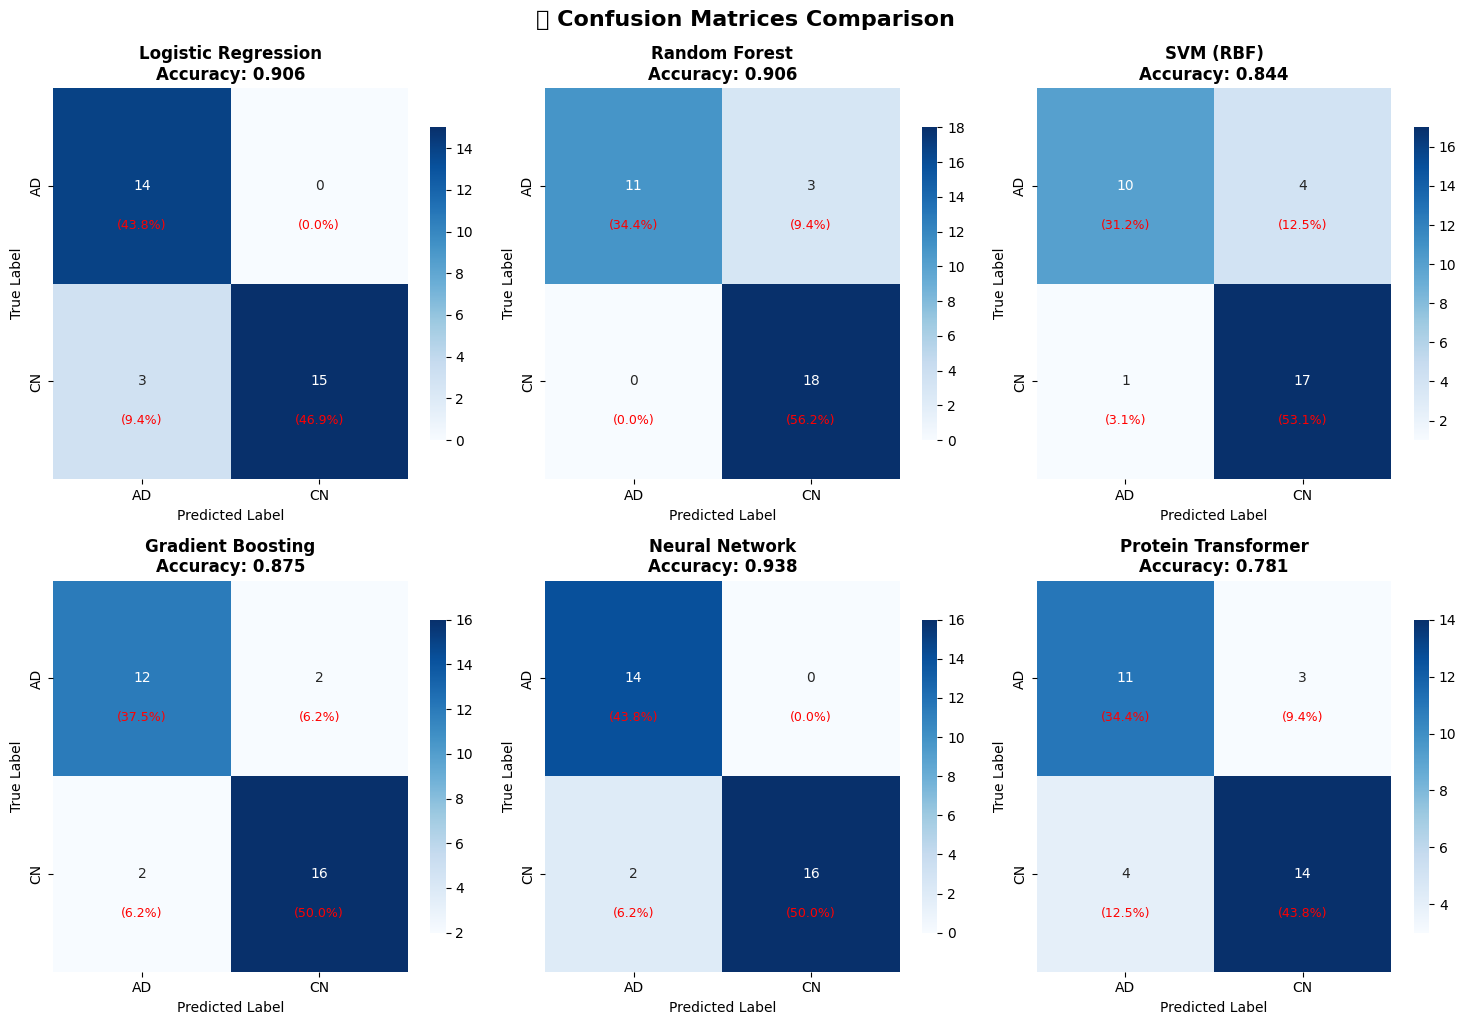

In [11]:
# Create comprehensive confusion matrix visualization
def plot_confusion_matrices():
    """Plot confusion matrices for all classifiers in a tidy grid"""
    
    # Calculate grid dimensions
    n_models = len(detailed_results)
    cols = 3  # 3 columns for tidy layout
    rows = (n_models + cols - 1) // cols  # Ceiling division
    
    fig, axes = plt.subplots(rows, cols, figsize=(15, 5*rows))
    if rows == 1:
        axes = axes.reshape(1, -1)  # Ensure 2D array
    
    # Class names for labels
    class_names = list(le.classes_)
    
    # Plot each confusion matrix
    for idx, (clf_name, results) in enumerate(detailed_results.items()):
        row = idx // cols
        col = idx % cols
        ax = axes[row, col]
        
        # Calculate confusion matrix
        cm = confusion_matrix(y_test, results['y_pred'])
        
        # Create heatmap
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                   xticklabels=class_names, yticklabels=class_names,
                   cbar_kws={'shrink': 0.8})
        
        # Customize plot
        ax.set_title(f'{clf_name}\nAccuracy: {results["accuracy"]:.3f}', 
                    fontsize=12, fontweight='bold')
        ax.set_xlabel('Predicted Label', fontsize=10)
        ax.set_ylabel('True Label', fontsize=10)
        
        # Add percentage annotations
        total = cm.sum()
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                percentage = cm[i, j] / total * 100
                ax.text(j + 0.5, i + 0.7, f'({percentage:.1f}%)', 
                       ha='center', va='center', fontsize=9, color='red')
    
    # Hide empty subplots
    for idx in range(n_models, rows * cols):
        row = idx // cols
        col = idx % cols
        axes[row, col].set_visible(False)
    
    plt.tight_layout()
    plt.suptitle('🎯 Confusion Matrices Comparison', fontsize=16, fontweight='bold', y=1.02)
    plt.show()

# Plot confusion matrices
plot_confusion_matrices()


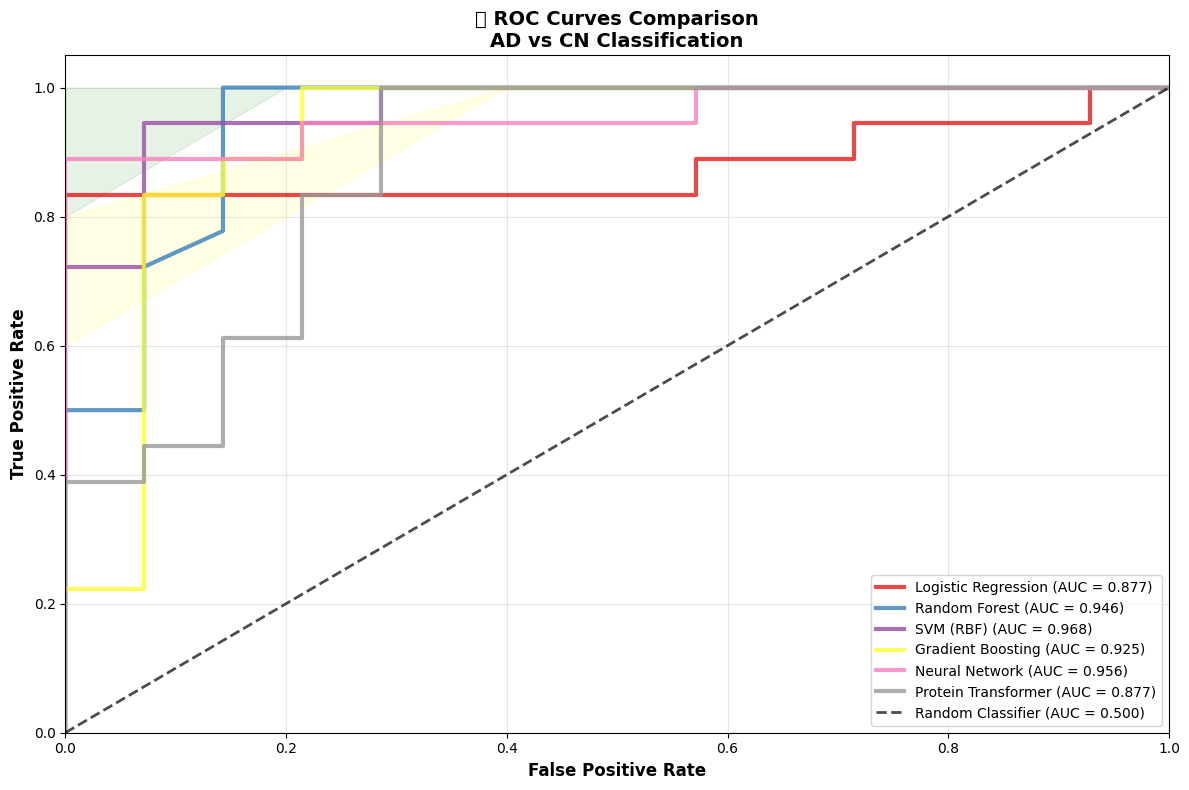

In [25]:
# Create comprehensive ROC curve visualization
def plot_roc_curves():
    """Plot ROC curves for all classifiers with AUC scores"""
    
    plt.figure(figsize=(12, 8))
    
    # Color palette for different classifiers
    colors = plt.cm.Set1(np.linspace(0, 1, len(detailed_results)))
    
    # Plot ROC curve for each classifier
    for idx, (clf_name, results) in enumerate(detailed_results.items()):
        if results['y_pred_proba'] is not None:
            # Calculate ROC curve
            fpr, tpr, _ = roc_curve(y_test, results['y_pred_proba'][:, 1])
            auc_score = results['auc']
            
            # Plot ROC curve
            plt.plot(fpr, tpr, linewidth=3, alpha=0.8, color=colors[idx],
                    label=f'{clf_name} (AUC = {auc_score:.3f})')
        else:
            print(f"⚠️ {clf_name}: No probability predictions available")
    
    # Plot random classifier line
    plt.plot([0, 1], [0, 1], 'k--', linewidth=2, alpha=0.7, label='Random Classifier (AUC = 0.500)')
    
    # Customize plot
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12, fontweight='bold')
    plt.ylabel('True Positive Rate', fontsize=12, fontweight='bold')
    plt.title('🎯 ROC Curves Comparison\nAD vs CN Classification', fontsize=14, fontweight='bold')
    plt.legend(loc="lower right", fontsize=10)
    plt.grid(True, alpha=0.3)
    
    # Add performance zones
    plt.fill_between([0, 0.2], [0.8, 1], [1, 1], alpha=0.1, color='green', label='Excellent Zone')
    plt.fill_between([0, 0.4], [0.6, 1], [0.8, 1], alpha=0.1, color='yellow', label='Good Zone')
    
    plt.tight_layout()
    plt.show()

# Plot ROC curves
plot_roc_curves()
